### Import Libraries

In [1]:
import findspark
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import datetime
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns



findspark.init()

### Create spark session

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [3]:
df = pd.read_csv('/dataset/nyc-jobs.csv')
print(df)


      Job ID                          Agency Posting Type  # Of Positions  \
0      87990    DEPARTMENT OF BUSINESS SERV.     Internal               1   
1      97899    DEPARTMENT OF BUSINESS SERV.     Internal               1   
2     132292           NYC HOUSING AUTHORITY     External              52   
3     132292           NYC HOUSING AUTHORITY     Internal              52   
4     133921           NYC HOUSING AUTHORITY     Internal              50   
...      ...                             ...          ...             ...   
2941  426214  HOUSING PRESERVATION & DVLPMNT     External               1   
2942  426214  HOUSING PRESERVATION & DVLPMNT     Internal               1   
2943  426223  HOUSING PRESERVATION & DVLPMNT     Internal               1   
2944  426223  HOUSING PRESERVATION & DVLPMNT     External               1   
2945  426238         DEPARTMENT OF BUILDINGS     Internal               1   

                                         Business Title  \
0               

### Data profiling

In [5]:
profile = ProfileReport(df, title="NYC-Jobs Profiling Report")
profile.to_file("NYC JObs.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Cleansing function

In [8]:
# function to clean the dataframe
def cleansing_data(df):
    
    # convert data datatype column to date type
    df['Posting Date'] = pd.to_datetime(df['Posting Date'], errors='coerce')
    df['Post Until'] = pd.to_datetime(df['Post Until'], errors='coerce')
  
    # Fill missing values in Minimum Qual Requirements and Preferred Skills columns
    df = df.fillna({"Minimum Qual Requirements": "Not specified", "Preferred Skills": "Not specified"})
    
    # rename columns using a dictionary
    df = df.rename(columns={'# Of Positions': 'Vaccant Position', 'Full-Time/Part-Time indicator': 'Job Type', 'Work Location 1': 'Office Address'})
    
   
    # Removing leading and trailing white spaces
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
    
     # drop columns with all null values
    df = df.dropna(axis=1, how='all')

    # drop rows with all null values
    df = df.dropna(how='all')
    
    df = df.replace('\t', ' ', regex=True)
    
    # remove duplicate rows
    df.drop_duplicates(inplace=True)

    
    # Drop irrelevant columns
    df = df.drop(["Job ID", "Posting Updated", "Process Date"], axis=1)

    
     # replace missing values in Job Category column with 'Unknown'
    df['Job Category'] = df['Job Category'].fillna('Unknown')
     
    # Convert Salary Range From and Salary Range To columns to numerical data type
    df['Salary Range From'] = df['Salary Range From'].astype(float)
    df['Salary Range To'] = df['Salary Range To'].astype(float)

    # Feature engineering techniques
    # 1. Create a new column 'Salary Range Avg' as the average of 'Salary Range From' and 'Salary Range To'
    df['Salary Range Avg'] = (df['Salary Range From'] + df['Salary Range To']) / 2

    # 2. Create a new column 'Posting Type' by one-hot encoding 'Posting Type' column
        
    df['Posting Type Index'], _ = pd.factorize(df['Posting Type'])

    # 3. Create a new column 'Degree Required' indicating whether a higher degree is required or not
    df['Degree Required'] = df['Minimum Qual Requirements'].str.contains('Master', case=False).map({True: 'Yes', False: 'No'})
    
    #  print(df['Degree Required'])
    # Remove columns that are not useful for analysis
    columns_to_drop = ["Salary Range From", "Salary Range To", "Posting Type", "Posting Type Index"]
    df = df.drop(columns_to_drop, axis=1)

    
    return df

### invoking function

In [9]:
clean_df = cleansing_data(df)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
clean_df.to_csv('/dataset/nyc-jobs-processed.csv', index=False)


## KPI's

### Top Ten Category

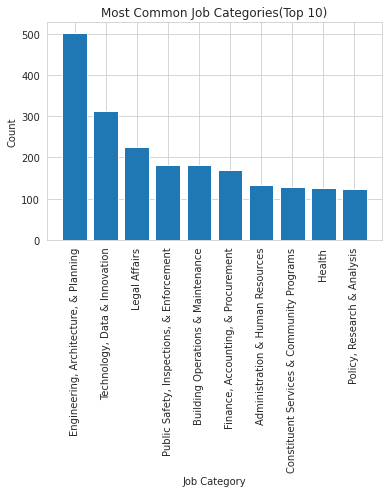

In [92]:
#clean_df=clean_df[['Job Category',]]
category_counts = clean_df['Job Category'].value_counts()
top_categories  = category_counts[:10]
# Create a bar chart
plt.bar(top_categories.index, top_categories.values)

# Set chart title and axis labels
plt.title('Most Common Job Categories(Top 10)')
plt.xlabel('Job Category')
plt.ylabel('Count')

# Rotate x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# Display the chart
plt.show()



### Whats the salary distribution per job category?

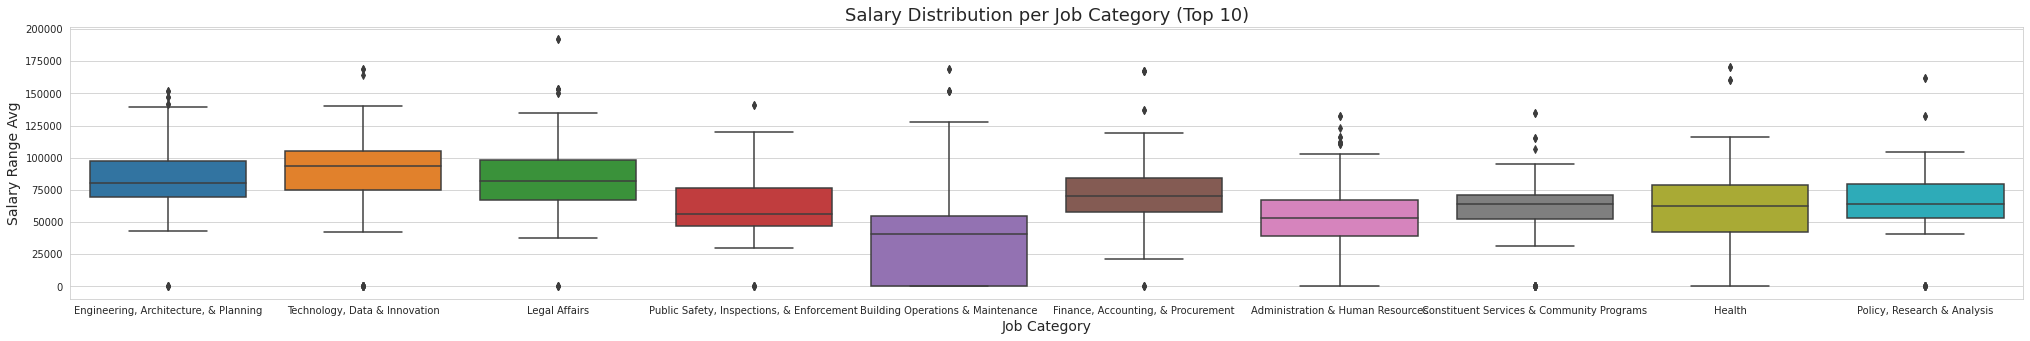

In [97]:
top_10_categories = clean_df['Job Category'].value_counts().nlargest(10).index.tolist()
salary_dist_df = clean_df[clean_df['Job Category'].isin(top_10_categories)]
plt.figure(figsize=(35,5))
sns.boxplot(x='Job Category', y='Salary Range Avg', data=salary_dist_df, order=top_10_categories)
plt.title('Salary Distribution per Job Category (Top 10)', fontsize=18)
plt.xlabel('Job Category', fontsize=14)
plt.ylabel('Salary Range Avg', fontsize=14)
plt.show()

In [55]:
clean_df["degree_int"] = clean_df["Minimum Qual Requirements"].str.contains("Bachelor|Master|PhD", regex=True).astype(int)

# Calculate the correlation between `degree_int` and `Salary Avg`
degree_salary_corr = clean_df["degree_int"].corr(clean_df["Salary Range Avg"])



0.09915402458674959


### Whats the job posting having the highest salary per agency?

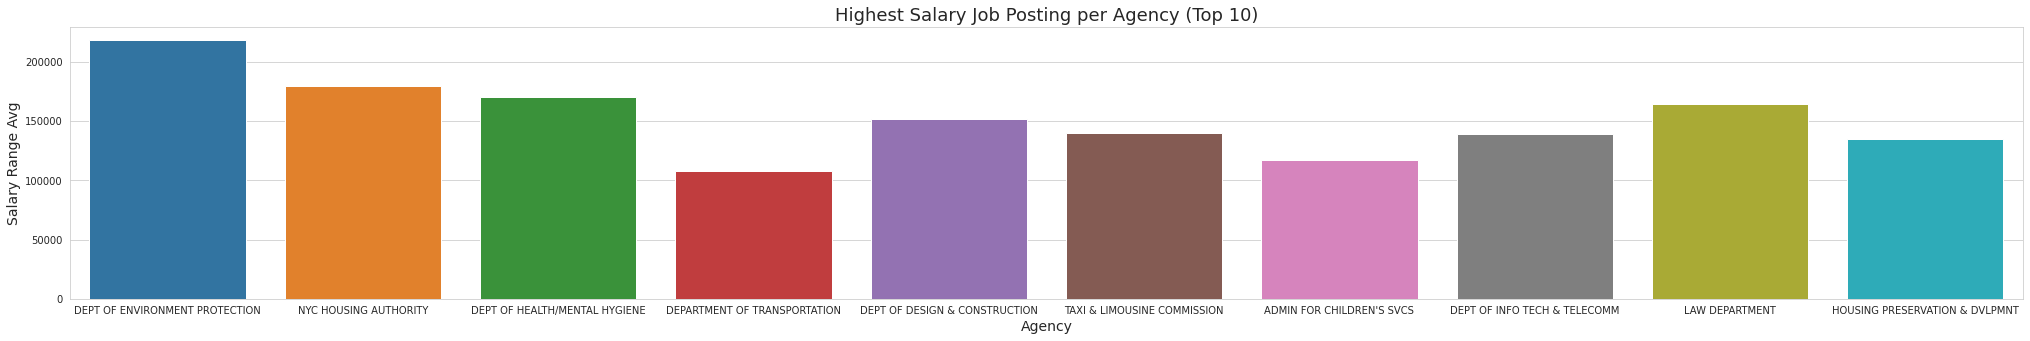

In [98]:
top_10_agencies = clean_df['Agency'].value_counts().nlargest(10).index.tolist()

result_df = clean_df[clean_df['Agency'].isin(top_10_agencies)]
result_df = result_df.sort_values('Salary Range Avg', ascending=False).groupby('Agency').first().reset_index()

plt.figure(figsize=(35, 5))
sns.barplot(x='Agency', y='Salary Range Avg', data=result_df, order=top_10_agencies)
plt.title('Highest Salary Job Posting per Agency (Top 10)', fontsize=18)
plt.xlabel('Agency', fontsize=14)
plt.ylabel('Salary Range Avg', fontsize=14)
plt.show()

In [58]:

# Filter job postings from the last 2 years
current_year = datetime.datetime.now().year
two_years_ago = current_year - 2

recent_df = clean_df[clean_df["Posting Date"].dt.year >= two_years_ago]

# Group by Agency and calculate mean salary
result_df = recent_df.groupby("Agency")["Salary Range Avg"].mean().reset_index()
#print(result_df)


Empty DataFrame
Columns: [Agency, Salary Range Avg]
Index: []


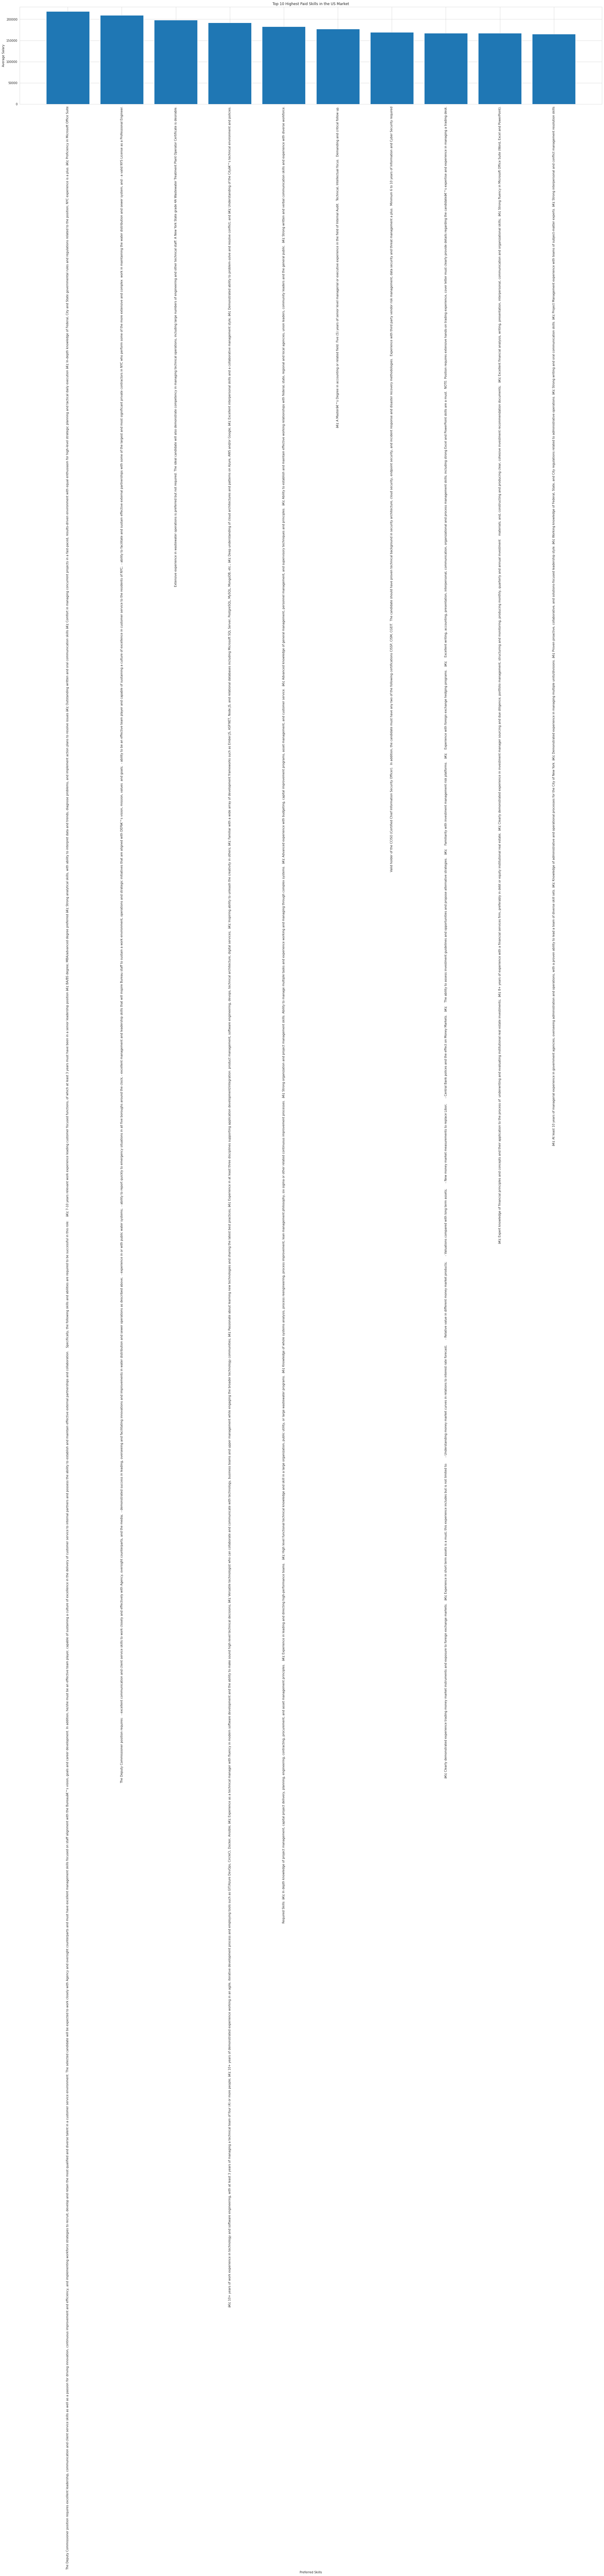

In [107]:
# Group the job postings by skill and calculate the average salary for each group
skill_salaries = clean_df.groupby('Preferred Skills')['Salary Range Avg'].mean()

# Sort the skills by average salary in descending order
sorted_skills_salary = skill_salaries.sort_values(ascending=False)

# Take the top 10 highest paid skills
top_skills = sorted_skills_salary[:10]

# Create a bar graph of the top 10 highest paid skills
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(35, 6))

ax.bar(top_skills.index, top_skills.values)
plt.xticks(rotation=90)
plt.xlabel('Preferred Skills')
plt.ylabel('Average Salary')
plt.title('Top 10 Highest Paid Skills in the US Market')
plt.show()
